## Project 3: Web APIs & NLP

### Goal:
1. Use Pushshift's API to collect posts from two subreddits of your choosing.
2. Then use NLP to train a classifier on which subreddit a given post came from.

## Navigator

1. [Scraping](#p1) 
2. [Exploratory Data Analysis (EDA)](#p2)
3. [Vectorising Scraped Data](#p3)
    - [Count Vectorisation](#p4)
    - [N-grams Vectorisation](#p5)
    - [TF-IDF Vectorisation](#p6)
4. [Model Evaluation Summary](#p7)
    - [Train/Test on Count Vect Data](#p8)
    - [Train/Test on N-grams Data](#p9)
    - [Train/Test on TF-IDF Data](#p10)
5. [Modelling on TF-IDF Data (Best Dataset)](#p11)
    - [Bernoulli Naive Bayes](#p12)
    - [Multinomial Naive Bayes](#p13)
    - [Gaussian Naive Bayes](#p14)
    - [Logistic Regression](#p15)
    - [K-Nearest Neighbour](#p16)

<a id='p1'></a>
## Part 1 - Scraping

In [1]:
import pandas as pd
import numpy as np
import requests
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
# from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_roc_curve, roc_auc_score, accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB


In [2]:
# Tweak display settings
pd.set_option('display.max_columns', 5555)
pd.set_option('display.max_rows', 5555)

In [3]:
# URL for API call - Perfumes
url = 'https://api.pushshift.io/reddit/search/submission?subreddit=Perfumes'

In [4]:
# Submit request
req_perf = requests.get(url)

In [5]:
# Checking response code
req_perf.status_code

200

In [6]:
# # Checking contents
# req_perf.text

In [7]:
# Converting to JSON
perf = req_perf.json()

In [8]:
# Understanding nature of scraped data
type(perf)

dict

In [9]:
# Getting info on keys
perf.keys()

dict_keys(['data'])

In [10]:
# No other nested keys, data layer no attribute 'keys'
# perf['data'].keys() - AttributeError, no keys

In [11]:
# Saving scraped data into a dataframe
df_perf = pd.DataFrame(perf['data'])

In [12]:
# df preview
df_perf.head(2)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,treatment_tags,upvote_ratio,url,url_overridden_by_dest,whitelist_status,wls,link_flair_template_id,link_flair_text,removed_by_category,gallery_data,is_gallery,media_metadata,discussion_type,suggested_sort
0,[],False,svetlana23,None,[],None,text,t2_4ei743br,False,False,False,[],False,False,1661423711,i.redd.it,https://www.reddit.com/r/Perfumes/comments/wxa...,{},wxao0l,False,True,False,False,True,True,False,False,,[],dark,text,False,False,False,0,0,False,all_ads,/r/Perfumes/comments/wxao0l/can_somebody_help_...,False,image,"{'enabled': True, 'images': [{'id': '9ON9smSXj...",6,1661423721,1,,True,False,False,Perfumes,t5_2s8y4,16181,public,https://b.thumbs.redditmedia.com/ODSphR16GUmoh...,140.0,140.0,Can somebody help me identify this? Got it fro...,0,[],1.0,https://i.redd.it/4so5diu58uj91.jpg,https://i.redd.it/4so5diu58uj91.jpg,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,newtonpics,None,[],None,text,t2_ye3bp,False,False,False,[],False,False,1661419264,self.Perfumes,https://www.reddit.com/r/Perfumes/comments/wx9...,{},wx9el4,False,True,False,False,False,True,True,False,#0079d3,"[{'e': 'text', 't': 'Discussion '}, {'a': ':sn...",light,richtext,False,False,True,0,0,False,all_ads,/r/Perfumes/comments/wx9el4/ok_for_mens_perfum...,False,NaN,NaN,6,1661419274,1,,True,False,False,Perfumes,t5_2s8y4,16181,public,self,NaN,NaN,Ok for mens perfume here?,0,[],1.0,https://www.reddit.com/r/Perfumes/comments/wx9...,NaN,all_ads,6,692f1192-c21f-11ea-a4f8-0e90b6858235,Discussion :snoo_tableflip::snoo_thoughtful:,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
soup_perf = BeautifulSoup(req_perf.content, 'lxml')

In [14]:
### All steps repeated for 2nd topic
url = 'https://api.pushshift.io/reddit/search/submission?subreddit=MakeUp'
req_makeup = requests.get(url)
req_makeup.status_code
makeup = req_makeup.json()
df_makeup = pd.DataFrame(makeup['data'])
soup_makeup = BeautifulSoup(req_makeup.content, 'lxml')

In [15]:
df_makeup.head(2)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,link_flair_template_id,link_flair_text,removed_by_category,post_hint,preview,crosspost_parent,crosspost_parent_list,thumbnail_height,thumbnail_width,url_overridden_by_dest
0,[],False,thecolorginger,None,[],None,text,t2_qiq5tycq,False,False,False,[],False,False,1661429427,self.Makeup,https://www.reddit.com/r/Makeup/comments/wxcjs...,{},wxcjsg,False,True,False,False,False,True,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/Makeup/comments/wxcjsg/can_i_use_laura_merc...,False,6,1661429438,1,Hello! Can I use this as an oil control withou...,True,False,False,Makeup,t5_2qrwc,1416508,public,top,self,can I use Laura Mercier translucent powder alo...,0,[],1.0,https://www.reddit.com/r/Makeup/comments/wxcjs...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,pndhs,None,[],None,text,t2_1r1adnjv,False,False,False,[],False,False,1661425928,self.Makeup,https://www.reddit.com/r/Makeup/comments/wxbcz...,{},wxbczf,False,True,False,False,False,True,True,False,,"[{'e': 'text', 't': '[Makeup Help]'}]",dark,richtext,False,False,True,0,0,False,all_ads,/r/Makeup/comments/wxbczf/how_the_hell_do_i_us...,False,6,1661425938,1,"I bought a soft ""pencil"" eyeliner (Beyu Soft ...",True,False,False,Makeup,t5_2qrwc,1416451,public,top,self,How the hell do i use my soft eyeliner?,0,[],1.0,https://www.reddit.com/r/Makeup/comments/wxbcz...,all_ads,6,0eb429a6-3b52-11e3-ad3c-12313d184137,[Makeup Help],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def scrape(topic, n= 8888):
    # URL to scrape
    url = f'https://api.pushshift.io/reddit/search/submission?subreddit={topic}&size=500'
    print(f'URL scraped from: {url}')
    
    # Empty list to store data
    data = []
    
    # Loop to scrape
    for i in range(1, n):
        # using multiples of 30 for archive date
        url_arch = '{}&after={}d'.format(url, 30*i)
        print(f'URL scraped from: {url_arch}, Archived days: {30*i} days ago')
        req = requests.get(url_arch)
        
        if req.status_code != 200:
            print('Status code =/= 200 !!!')
            
        scraped = req.json()['data']
        # Storing scraped JSON into a df
        df = pd.DataFrame.from_dict(scraped)
        # Append scraped data to empty list
        data.append(df)
        
        total_scraped = sum(len(x) for x in data)
        # Print total posts scrapped to see how many posts the function has scrapped
        print(f'total_scraped: {total_scraped}')
        
        # end scrape once count > n
        if total_scraped > n:
            break
            
        # sleep cycle
        sleeping = random.randint(1,6)
        time.sleep(sleeping)
        
    # Combine all iterations into 1 dataframe
    # if you don't do this step, it looks like it returns only the last entry
    final_df = pd.concat(data, sort=False)
    
    # filter columns we're only interested in
    final_df = final_df[['created_utc', 'subreddit', 'title', 'selftext']]

    return final_df

### Uncomment cells 17 - 22 to re-scrape

In [17]:
# %%time
# data_perf = scrape('Perfumes')

In [18]:
# display(data_perf.head(3))
# data_perf.count()

In [19]:
# %%time
# data_makeup = scrape('MakeUp')

In [20]:
# display(data_makeup.head(3))
# data_makeup.count()

In [21]:
# # Merge datasets together
# data_merged = pd.concat([data_perf, data_makeup])

In [22]:
# # Saving datasets to avoid rescraping
# data_perf.to_csv('./datasets/data_perfume.csv', index=False)
# data_makeup.to_csv('./datasets/data_makeup.csv', index=False)
# data_merged.to_csv('./datasets/data_merged.csv', index=False)

### Import files with scraped data

In [23]:
data_perf = pd.read_csv('./datasets/data_perfume.csv')
data_makeup = pd.read_csv('./datasets/data_makeup.csv')
data_merged = pd.read_csv('./datasets/data_raw.csv')

In [24]:
# Checking result
display(data_merged.shape)
data_merged.head(3)

(17998, 4)

,created_utc,subreddit,title,selftext
0,1658770474,Perfumes,Best place to find samples?,Hi everyone! I’m pretty new to the fragrance w...
1,1658771447,Perfumes,In case you're into arab fragrances:),NaN
2,1658771490,Perfumes,Anyone can tell me about Lorenzo Villoresi per...,Have you tried any? What is your favorite and ...


In [25]:
# Adding classification column, 0 for perfume, 1 for makeup
data_merged['class_p_mu'] = data_merged['subreddit'].map({'Perfumes':0, 'Makeup':1})

In [26]:
# Checking mapping results
data_merged['class_p_mu'].value_counts()

1    9000
0    8998
Name: class_p_mu, dtype: int64

<a id='p2'></a>
### Basic EDA on both datasets' posts: `selftext`

In [27]:
display(data_perf.isnull().sum())
data_makeup.isnull().sum()

created_utc       0
subreddit         0
title             0
selftext       4205
dtype: int64

created_utc      0
subreddit        0
title            0
selftext       525
dtype: int64

In [28]:
# Due to large counts of null values, decision is to combine 'title' and 'selftext' columns
data_perf = data_perf.fillna(' ')
data_perf['fulltext'] = data_perf['title'] + ' ' + data_perf['selftext']
data_makeup = data_makeup.fillna(' ')
data_makeup['fulltext'] = data_makeup['title'] + ' ' + data_makeup['selftext']

In [29]:
# New column that reflects length of post (title + body)
data_perf['post_length'] = data_perf['fulltext'].map(len)
data_makeup['post_length'] = data_makeup['fulltext'].map(len)

In [30]:
# New column that reflects number of words in each status
data_perf['post_word_count'] = data_perf['fulltext'].map(lambda x: len(x.split()))
data_makeup['post_word_count'] = data_makeup['fulltext'].map(lambda x: len(x.split()))

### EDA on Perfume & Makeup

In [31]:
# 3 shortest posts - Perfume
display(data_perf.sort_values(by='post_word_count', ascending=True)[['fulltext']].head(3))

# 3 shortest posts - Makeup
data_makeup.sort_values(by='post_word_count', ascending=True)[['fulltext']].head(3)

,fulltext
594,Casaniche
5214,Help!!
855,Mancera


,fulltext
434,ismr
8571,1080p
4526,https://www.etsy.com/shop/LashedupCo


In [32]:
# 3 longest posts - Perfume
display(data_perf.sort_values(by='post_word_count', ascending=False)[['fulltext']].head(3))

# 3 longest posts - Makeup
data_makeup.sort_values(by='post_word_count', ascending=False)[['fulltext']].head(3)

,fulltext
484,[GUIDE] The Most Useful Fragrance Beginner Gui...
4400,Perfume Parlour clone house review This post i...
4086,Perfume Parlour clone house review This post i...


,fulltext
473,Stash or Trash? • Monthly Makeup Routine Resul...
550,Stash or Trash? Monthly Makeup Routine Reviews...
8315,Please help!! mainly for recommendations on MA...


C:\Users\assau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


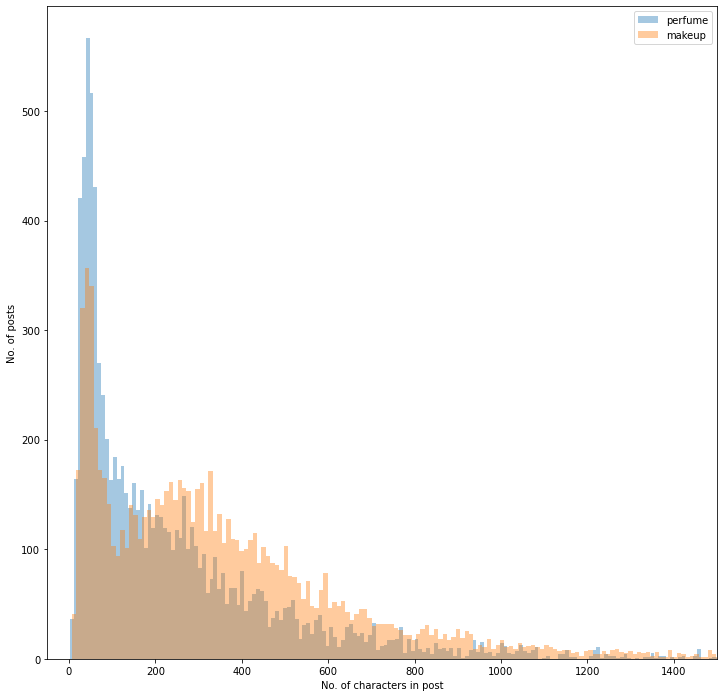

In [33]:
# distribution of post length (based on characters)
plt.figure(figsize=(12,12))

# Check why not working
plt.legend(labels=["perfume","makeup"])

plt.xlim(-50, 1500)
# Distribution plot
sns.distplot(data_perf['post_length'], bins=3000, kde=False, label='perfume')
sns.distplot(data_makeup['post_length'], bins=1000, kde=False, label='makeup')
plt.xlabel('No. of characters in post')
plt.ylabel('No. of posts')
plt.legend();

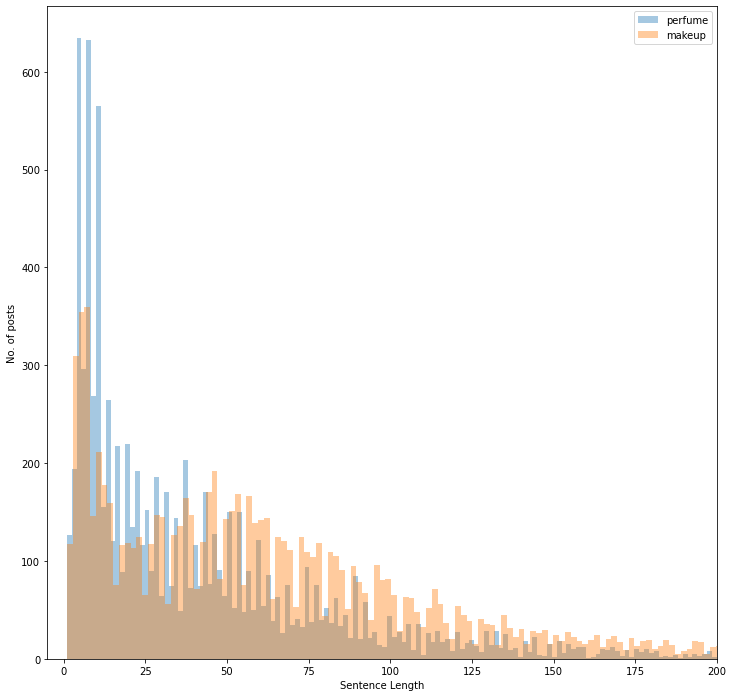

In [34]:
# distribution of post word count
plt.figure(figsize=(12,12))

# Distribution plot
sns.distplot(data_perf['post_word_count'], bins=3000, kde=False, label='perfume')
sns.distplot(data_makeup['post_word_count'], bins=1000, kde=False, label='makeup')
plt.xlim(-5, 200)
plt.xlabel('Sentence Length')
plt.ylabel('No. of posts')
plt.legend();

#### Takeaway: 
    - Both datasets left skewed, perfume larger skew
    - Perfume generally have shorter posts

In [35]:
# Perfume: Count vectoriser to get idea of each word occurence
cv = CountVectorizer(stop_words='english', min_df=3)
cv.fit(data_perf['fulltext'])

perf_cv = cv.transform(data_perf['fulltext'])
perf_cv_df = pd.DataFrame(perf_cv.todense(), columns=cv.get_feature_names())

C:\Users\assau\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
# Drop root word & variations
perf_cv_df.drop(columns=['perfume', 'perfumes'], inplace= True)
perf_cv_df.head(2)

00  000  0006738  00pm  01  02ae033012a47a3e9912bb0d082860f188f48719  04  \
0   0    0        0     0   0                                         0   0   
1   0    0        0     0   0                                         0   0   

   05  0557864490  07  08  0m1acacrxzw41  10  100  1000  10001  100ml  100th  \
0   0           0   0   0              0   0    0     0      0      0      0   
1   0           0   0   0              0   0    0     0      0      0      0   

   1018  10358  1080  10ml  10pm  11  110  111  112  114  114011045708  115  \
0     0      0     0     0     0   0    0    0    0    0             0    0   
1     0      0     0     0     0   0    0    0    0    0             0    0   

   1152  1163925000  12  120  1200  125  125ml  1280  1292171250769571840  13  \
0     0           0   0    0     0    0      0     0                    0   0   
1     0           0   0    0     0    0      0     0                    0   0   

   130  1300  1350  138b17ac  14  1432  1440  1451  1481  1488  \
0    0     0     0         0   0     0     0     0     0     0   
1    0     0     0         0   0     0     0     0     0     0   

   1494c5b359dec713dd2ce0c89b7df410cb33e371  15  150  1598532928  15ml  16  \
0                                         0   0    0           0     0   0   
1                                         0   0    0           0     0   0   

   1638840  17  1702  17f  17th  18  180  1805  180cm  1848  1881  1887  189  \
0        0   0     0    0     0   0    0     0      0     0     0     0    0   
1        0   0     0    0     0   0    0     0      0     0     0     0    0   

   18m  18th  19  190  1920  19255  195  1970  1970s  1980  1988  1990s  1994  \
0    0     0   0    0     0      0    0     0      0     0     0      0     0   
1    0     0   0    0     0      0    0     0      0     0     0      0     0   

   1998  19f  19m  19th  1bd1d109ada0f5af340713ebf6907f45f76ffa4b  \
0     0    0    0     0                                         0   
1     0    0    0     0                                         0   

   1c1chbf_enfr837fr837  1click4all  1dbcfb9ae919da1eda035d90b8899dafc400ad58  \
0                     0           0                                         0   
1                     0           0                                         0   

   1st  1vrtyzpuvsejrkgxmdxtnftijgq7vfbgg  1xcbi0aen5jldq  \
0    0                                  0               0   
1    0                                  0               0   

   1xcbi0aen5jldq_rmi_sdymnbp5acc  20  200  2000  2000s  2002  2003  2004  \
0                               0   0    0     0      0     0     0     0   
1                               0   0    0     0      0     0     0     0   

   2005  2006  2007  2008  2009  200ml  2010  2011  2012  2013  2014  2015  \
0     0     0     0     0     0      0     0     0     0     0     0     0   
1     0     0     0     0     0      0     0     0     0     0     0     0   

   2016  2017  2018  2019  2020  2021  2022  20ish  20m  20ml  20s  21  212  \
0     0     0     0     0     0     0     0      0    0     0    0   0    0   
1     0     0     0     0     0     0     0      0    0     0    0   0    0   

   21f  21m  22  2250  22f  23  2352  23f  24  240  25  250  250ml  25m  26  \
0    0    0   0     0    0   0     0    0   0    0   0    0      0    0   0   
1    0    0   0     0    0   0     0    0   0    0   0    0      0    0   0   

   26f  26hash  27  270  2756  28  29  2970  2f  2f152657427472  2fitm  \
0    0       0   0    0     0   0   0     0   0               0      0   
1    0       0   0    0     0   0   0     0   0               0      0   

   2ftester  2fwww  2hrs  2nd  2oz  2pacx  30  300  3024  \
0         0      0     0    0    0      0   0    0     0   
1         0      0     0    0    0      0   0    0     0   

   30aa3cac9450c9a6efbdbf4773519bedf3534a8a  30f  30ml  30s  31  32  320  \
0                                         0    0     0    0   0 

Text(0.5, 0, 'Occurences')

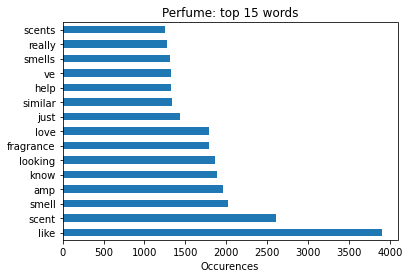

In [37]:
perf_cv_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Perfume: top 15 words')
plt.xlabel('Occurences')

In [38]:
# Make Up: Count vectoriser to get idea of each word occurence
cv.fit(data_makeup['fulltext'])
makeup_cv = cv.transform(data_makeup['fulltext'])
makeup_cv_df = pd.DataFrame(makeup_cv.todense(), columns=cv.get_feature_names())

C:\Users\assau\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
# Drop root word & variations
makeup_cv_df.drop(columns=['makeup', 'make', 'makeups', 'ups'], inplace= True)
makeup_cv_df.head(2)

00  000  00s  01  02  03  04  05  06  08  09  10  100  1000  101  102  105  \
0   0    0    0   0   0   0   0   0   0   0   0   0    0     0    0    0    0   
1   0    0    0   0   0   0   0   0   0   0   0   0    0     0    0    0    0   

   10th  11  110  118  12  120  13  130  14  140  15  150  16  16f  16hr  17  \
0     0   0    0    0   0    0   0    0   0    0   0    0   0    0     0   0   
1     0   0    0    0   0    0   0    0   0    0   0    0   0    0     0   0   

   170  17f  17th  18  18m  19  19f  1g  1st  20  200  2010  2012  2013  2015  \
0    0    0     0   0    0   0    0   0    0   0    0     0     0     0     0   
1    0    0     0   0    0   0    0   0    0   0    0     0     0     0     0   

   2016  2017  2018  2019  2020  2021  2022  208  20grid  20s  21  210  21f  \
0     0     0     0     0     0     0     0    0       0    0   0    0    0   
1     0     0     0     0     0     0     0    0       0    0   0    0    0   

   21st  22  220  22f  23  238  24  24f  24h  24hr  25  250  25f  26  260  \
0     0   0    0    0   0    0   0    0    0     0   0    0    0   0    0   
1     0   0    0    0   0    0   0    0    0     0   0    0    0   0    0   

   26f  27  27f  28  29  2nd  2w2  30  300  30s  30th  31  32  33  330  34  \
0    0   0    0   0   0    0    0   0    0    0     0   0   0   0    0   0   
1    0   0    0   0   0    0    0   0    0    0     0   0   0   0    0   0   

   34f  35  36  37  37137  37f  38  39  3ce  3d  3rd  3x  40  400  40s  41  \
0    0   0   0   0      0    0   0   0    0   0    0   0   0    0    0   0   
1    0   0   0   0      0    0   0   0    0   0    0   0   0    0    0   0   

   42  420  43  44  45  46  48  49  4th  50  52  5n  60  60s  61  62  63  65  \
0   0    0   0   0   0   0   0   0    0   0   0   0   0    0   0   0   0   0   
1   0    0   0   0   0   0   0   0    0   0   0   0   0    0   0   0   0   0   

   68  6g  70  75  7th  80  85  86  8th  90  90s  95  96  98  99  _wcb  ab  \
0   0   0   0   0    0   0   0   0    0   0    0   0   0   0   0     0   0   
1   0   0   0   0    0   0   0   0    0   0    0   0   0   0   0     0   0   

   abh  abh01  ability  able  absolute  absolutely  absorb  absorbed  \
0    0      0        0     0         0           0       0         0   
1    0      0        0     0         0           0       0         0   

   absorbing  abt  ac  academy  accents  accentuate  accentuated  accentuates  \
0          0    0   0        0        0           0            0            0   
1          0    0   0        0        0           0            0            0   

   accept  accepted  accepting  access  accessible  accessories  accident  \
0       0         0          0       0           0            0         0   
1       0         0          0       0           0            0         0   

   accidental  accidentally  accomplish  according  account  accounts  \
0           0             0           0          0        0         0   
1           0             0           0          0        0         0   

   accumulated  accurate  accurately  accutane  ache  achieve  achieved  \
0            0         0           0         0     0        0         0   
1            0         0           0         0     0        0         0   

   achieving  acid  acne  acquired  acrylates  acrylic  act  action  \
0          0     0     0         0          0        0    0       0   
1          0     0     0         0          0        0    0       0   

   activated  active  actively  activity  actors  actress  acts  actual  \
0          0       0         0         0       0        0     0       0   
1          0       0         0         0       0        0     0       0   

   actually  ad  add  adda  added  addict  addicted  addiction  addicts  \
0         0   0    0     0      0       0         0          0        0   
1         0   0    0     0      0       0         0          0        0   

   adding  addition  additional  additionally  addres

Text(0.5, 0, 'Occurences')

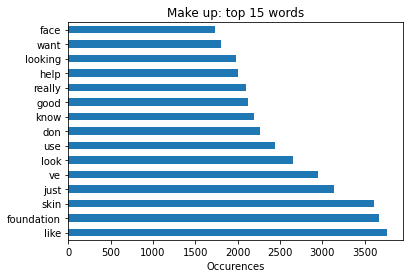

In [40]:
makeup_cv_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Make up: top 15 words')
plt.xlabel('Occurences')

Some common English word overlaps but strong keywords in each dataset. \
Perfume: scent, smell, fragrance \
Make up: foundation, skin, look

<a id='p3'></a>
## Part 2 using NLP to classify

In [41]:
# Due to large counts of null values, decision is to combine 'title' and 'selftext' columns
data_merged = data_merged.fillna(' ')
data_merged['fulltext'] = data_merged['title'] + ' ' + data_merged['selftext']

In [42]:
# checking data integrity
data_merged['fulltext'].size

17998

In [43]:
# function to remove punctuations
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

In [44]:
data_merged['full_clean'] = data_merged['fulltext'].apply(lambda x: remove_punct(x))

In [45]:
# function to tokenise string of sentences
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

In [46]:
data_merged['full_token'] = data_merged['full_clean'].apply(lambda x: tokenize(x.lower()))

In [47]:
# Initiating stopwords
stopword = nltk.corpus.stopwords.words('english')

# Additional stopwords - remove root words
addstop = [ 'makeup', 'makeups', 'make', 'up', 'ups', 'perfume', 'perfumes']

# Extending list of stopwords
stopword.extend(addstop)

In [48]:
# function to remove stopwords
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    text = [word for word in text if word != '']
    return text

In [49]:
data_merged['full_nostop'] = data_merged['full_token'].apply(lambda x: remove_stopwords(x))

In [50]:
# Initiating lemmatiser
wn = nltk.WordNetLemmatizer()

In [51]:
# function to lemmatise words
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

In [52]:
data_merged['full_lemmed'] = data_merged['full_nostop'].apply(lambda x: lemmatizing(x))

In [53]:
# Convert column of lists to string
data_merged['full_clemmed'] = [' '.join(map(str, l)) for l in data_merged['full_lemmed']]

In [54]:
data_merged.head(3)

,created_utc,subreddit,title,selftext,class_p_mu,fulltext,full_clean,full_token,full_nostop,full_lemmed,full_clemmed
0,1658770474,Perfumes,Best place to find samples?,Hi everyone! I’m pretty new to the fragrance w...,0,Best place to find samples? Hi everyone! I’m p...,Best place to find samples Hi everyone I’m pre...,"[best, place, to, find, samples, hi, everyone,...","[best, place, find, samples, hi, everyone, pre...","[best, place, find, sample, hi, everyone, pret...",best place find sample hi everyone pretty new ...
1,1658771447,Perfumes,In case you're into arab fragrances:),,0,In case you're into arab fragrances:),In case youre into arab fragrances,"[in, case, youre, into, arab, fragrances, ]","[case, youre, arab, fragrances]","[case, youre, arab, fragrance]",case youre arab fragrance
2,1658771490,Perfumes,Anyone can tell me about Lorenzo Villoresi per...,Have you tried any? What is your favorite and ...,0,Anyone can tell me about Lorenzo Villoresi per...,Anyone can tell me about Lorenzo Villoresi per...,"[anyone, can, tell, me, about, lorenzo, villor...","[anyone, tell, lorenzo, villoresi, tried, favo...","[anyone, tell, lorenzo, villoresi, tried, favo...",anyone tell lorenzo villoresi tried favorite l...


<a id='p4'></a>
### Method 1: Count Vectorisation

In [55]:
ps = nltk.PorterStemmer()

In [56]:
# clean_text function to clean & lemmatise text
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopword]
    text = [word for word in text if word != '']
    return text

In [57]:
# Initiating CV, max_features limited to 3k
count_vect = CountVectorizer(analyzer=clean_text, max_features=3000)

In [58]:
# Creation of sparse matrix for 'Perfume'
merged_cvec = count_vect.fit_transform(data_merged['fulltext'])

In [59]:
# Convert sparse matrix to a df
merged_cvec_df = pd.DataFrame(merged_cvec.toarray())
# Labelling columns
merged_cvec_df.columns = count_vect.get_feature_names()
merged_cvec_df.shape

C:\Users\assau\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(17998, 3000)

<AxesSubplot:>

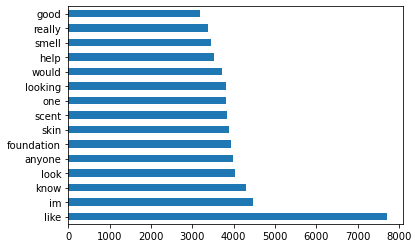

In [60]:
# Combined most occuring words
merged_cvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')

In [61]:
### FIGURE OUT WHEN HAVE TIME
# merged_cvec_df = pd.concat([merged_cvec_df, data_merged['class_p_mu']], axis=1)
# merged_cvec_df[merged_cvec_df['class_p_mu'] == '0'].sum().sort_values(ascending=False).head(15)

<a id='p5'></a>
## Method 2: N-grams

In [62]:
# checking cleaned & lemmed data column before proceeding
data_merged['full_clemmed'].head(3)

0    best place find sample hi everyone pretty new ...
1                            case youre arab fragrance
2    anyone tell lorenzo villoresi tried favorite l...
Name: full_clemmed, dtype: object

In [63]:
# N-grams vectorisation for only bigrams
ngram_vect = CountVectorizer(ngram_range=(2,2), max_features=3000)

merged_ngram = ngram_vect.fit_transform(data_merged['full_clemmed'])

In [64]:
# Converting N-Gram results to dataframe
merged_ngram_df = pd.DataFrame(merged_ngram.toarray())
merged_ngram_df.columns = ngram_vect.get_feature_names()

# Data Set has 193826 unique 2-word combinations
merged_ngram_df.shape

C:\Users\assau\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(17998, 3000)

<AxesSubplot:>

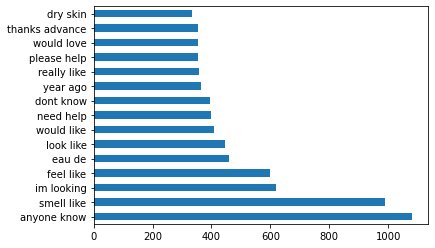

In [65]:
merged_ngram_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')

<a id='p6'></a>
## Method 3: TF-IDF

#### Application on Perfume dataset

In [66]:
# Initialising TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=3000)
merged_tfidf = tfidf_vect.fit_transform(data_merged['fulltext'])

In [67]:
merged_tfidf_df = pd.DataFrame(merged_tfidf.toarray())
merged_tfidf_df.columns = tfidf_vect.get_feature_names()
merged_tfidf_df.shape

C:\Users\assau\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(17998, 3000)

<a id='p7'></a>
## Model Evaluation Summary

**Evaluating Vectorisation Types**

|Vectorisation Type|Model Type|Train Results|Test Results|
|:--|:--|:-:|:-:|
|Count|Bernoulli NB|0.91082|0.90778|
|Count|Multinomial NB|0.96034|0.95417|
|Count|Gaussian NB|0.92742|0.92194|
|N-Gram|Bernoulli NB|0.87436|0.86889|
|N-Gram|Multinomial NB|0.84046|0.83472|
|N-Gram|Gaussian NB|0.85581|0.85139|
|**TF-IDF**|**Bernoulli NB**|**0.96027**|**0.95130**|
|**TF-IDF**|**Multinomial NB**|**0.97013**|**0.96361**|
|**TF-IDF**|**Gaussian NB**|**0.96325**|**0.94222**|

\
\
**Vectorisation Type 'TF-IDF' returns the best results so we apply subsequent models on it**

|Vectorisation Type|Model Type|Train Results|Test Results|
|:--|:--|:-:|:-:|
|TF-IDF|Bernoulli NB|0.96027|0.95130|
|**TF-IDF**|**Multinomial NB**|**0.97013**|**0.96361**|
|TF-IDF|Gaussian NB|0.96325|0.94222|
|**TF-IDF**|**Logistic Regression**|**0.98020**|**0.97000**|
|TF-IDF|K-Nearest Neighbour|0.95701|0.75278|


<a id='p8'></a>
### Classification Model: Naïve Bayes
### Using Count Vectorisation Data

In [68]:
# X = count vectorisation data
X = merged_cvec_df
y = data_merged['class_p_mu']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#### Bernoulli Naive Bayes model

In [70]:
# Instantiate & fit bernoulli model
BernNB = BernoulliNB(binarize=0.2)
BernNB.fit(X_train, y_train)

# Bernoulli Bayes model score
display(BernNB.score(X_train, y_train))
BernNB.score(X_test, y_test)

0.9108209473537991

0.9077777777777778

#### Multinomial Naive Bayes model

In [71]:
# Instantiate & fit Multinomial Bayes
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)

# Multinomial Bayes model score
display(MultiNB.score(X_train, y_train))
MultiNB.score(X_test, y_test)

0.9603417141269621

0.9541666666666667

#### Gaussian Naive Bayes model

In [72]:
# Instantiate & fit Gaussian Bayes
GausNB = GaussianNB()
GausNB.fit(X_train, y_train)

# Gaussian Bayes model score
display(GausNB.score(X_train, y_train))
GausNB.score(X_test, y_test)

0.9274204750659814

0.9219444444444445

<a id='p9'></a>
### Using N-grams Vectorisation data

In [73]:
# X = n-grams data
X = merged_ngram_df
y = data_merged['class_p_mu']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#### Bernoulli Naive Bayes model

In [75]:
# Instantiate & fit bernoulli model
BernNB = BernoulliNB(binarize=0.2)
BernNB.fit(X_train, y_train)

# Bernoulli Bayes model score
display(BernNB.score(X_train, y_train))
BernNB.score(X_test, y_test)

0.8743575496596749

0.8688888888888889

#### Multinomial Naive Bayes model

In [76]:
# Instantiate & fit Multinomial Bayes
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)

# Multinomial Bayes model score
display(MultiNB.score(X_train, y_train))
MultiNB.score(X_test, y_test)

0.840463953326851

0.8347222222222223

#### Gaussian Naive Bayes model

In [77]:
# Instantiate & fit Gaussian Bayes
GausNB = GaussianNB()
GausNB.fit(X_train, y_train)

# Gaussian Bayes model score
display(GausNB.score(X_train, y_train))
GausNB.score(X_test, y_test)

0.8558133074038061

0.8513888888888889

<a id='p10'></a>
### Using TF-IDF Vectorisation data

In [78]:
# X = TF-IDF data
X = merged_tfidf_df
y = data_merged['class_p_mu']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

<a id='p12'></a>
#### Bernoulli Naive Bayes model

In [80]:
# Instantiate & fit bernoulli model
BernNB = BernoulliNB(binarize=0.2)
BernNB.fit(X_train, y_train)

# Bernoulli Bayes model score
display(BernNB.score(X_train, y_train))
BernNB.score(X_test, y_test)

0.9602722600361161

0.9513888888888888

<a id='p13'></a>
#### Multinomial Naive Bayes model (TOP 2)

In [81]:
# Instantiate & fit Multinomial Bayes
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)

# Multinomial Bayes model score
display(MultiNB.score(X_train, y_train))
MultiNB.score(X_test, y_test)

0.9649951382136408

0.9577777777777777

##### Optimising Multinomial Naive Bayes - REPLACED default

In [82]:
# Optimal results found through trial and error
MultiNB = MultinomialNB(fit_prior=False)
MultiNB.fit(X_train, y_train)

# Optimised Multinomial NB model score
display(MultiNB.score(X_train, y_train))
MultiNB.score(X_test, y_test)

0.9701347409362412

0.9636111111111111

##### Confusion Matrix & Classification Report & ROC  for Top 2 Models

In [83]:
MultiNB_pred = MultiNB.predict(X_test)

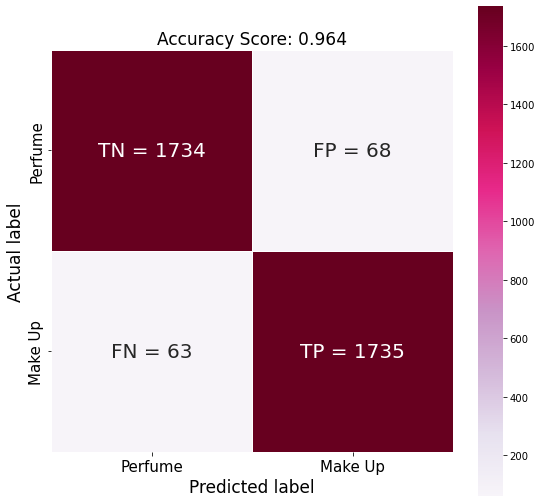

In [84]:
cm = confusion_matrix(y_test, MultiNB_pred)
score = MultiNB.score(X_test, y_test)

# Create modified labels for Confusion Matrix
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

# Plotting customised Confusion Matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'PuRd',
            xticklabels = ['Perfume', 'Make Up'],
            yticklabels = ['Perfume', 'Make Up'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 17);
plt.tick_params(labelsize= 15)

In [85]:
# Output as dict due to display issue - revisit
clf = classification_report(y_test, MultiNB_pred, output_dict=True)
clf_df = pd.DataFrame(clf).transpose()
clf_df

,precision,recall,f1-score,support
0,0.964942,0.962264,0.963601,1802.000000
1,0.962285,0.964961,0.963621,1798.000000
accuracy,0.963611,0.963611,0.963611,0.963611
macro avg,0.963613,0.963613,0.963611,3600.000000
weighted avg,0.963615,0.963611,0.963611,3600.000000


C:\Users\assau\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


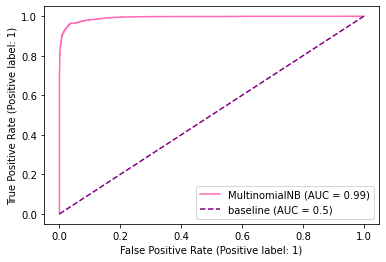

In [86]:
plot_roc_curve(MultiNB, X_test, y_test , color="hotpink")
plt.plot([0, 1], [0, 1], label='baseline (AUC = 0.5)', linestyle='--' , color="purple")
plt.legend();

<a id='p14'></a>
#### Gaussian Naive Bayes model

In [87]:
# Instantiate & fit Gaussian Bayes
GausNB = GaussianNB()
GausNB.fit(X_train, y_train)

# Gaussian Bayes model score
display(GausNB.score(X_train, y_train))
GausNB.score(X_test, y_test)

0.963258785942492

0.9422222222222222

### Since TF-IDF vectorisation method returned the best results, we run other models based on it

<a id='p15'></a>
#### Logistic Regression model (Top 2)

In [88]:
LogReg = LogisticRegression(solver = 'liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [89]:
# Logistic Regression model score
display(LogReg.score(X_train, y_train))
LogReg.score(X_test, y_test)

0.980205584108904

0.97

##### Optimisation for Logistic Regression - IGNORED
Trial and Error used instead of GridSearch since few parameters to test \
Default parameters used since no improvement

In [90]:
# penalty parameter adjusted to l1
LogReg2 = LogisticRegression(penalty ='l1',solver = 'liblinear')
LogReg2.fit(X_train, y_train)
display(LogReg2.score(X_train, y_train))
LogReg2.score(X_test, y_test)

0.9721489095707737

0.9566666666666667

Model deproved thus default penalty of 'l2' retained

##### Confusion Matrix & Classification Report & ROC  for Top 2 Models

In [91]:
LogReg_pred = LogReg.predict(X_test)

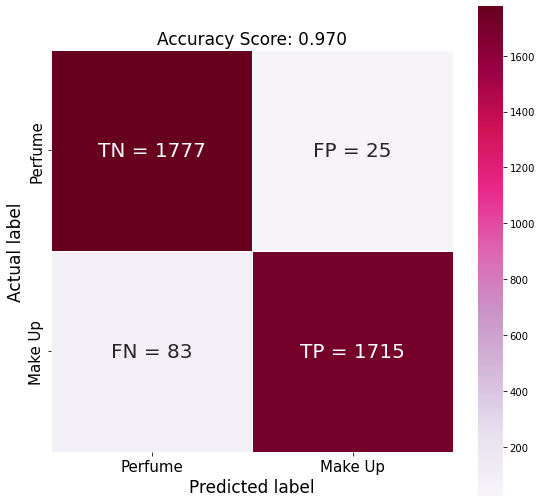

In [92]:
cm = confusion_matrix(y_test, LogReg_pred)
score = LogReg.score(X_test, y_test)

# Create modified labels for Confusion Matrix
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

# Plotting customised Confusion Matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'PuRd',
            xticklabels = ['Perfume', 'Make Up'],
            yticklabels = ['Perfume', 'Make Up'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 17);
plt.tick_params(labelsize= 15)

In [93]:
# convert report to df due to formatting error - REVISIT
clf = classification_report(y_test, LogReg_pred, output_dict=True)
clf_df = pd.DataFrame(clf).transpose()
clf_df

,precision,recall,f1-score,support
0,0.955376,0.986127,0.970508,1802.00
1,0.985632,0.953838,0.969474,1798.00
accuracy,0.970000,0.970000,0.970000,0.97
macro avg,0.970504,0.969982,0.969991,3600.00
weighted avg,0.970487,0.970000,0.969992,3600.00


C:\Users\assau\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


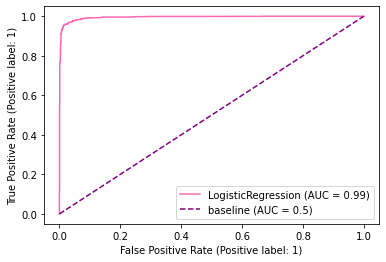

In [94]:
plot_roc_curve(LogReg, X_test, y_test, color="hotpink")
plt.plot([0, 1], [0, 1], label='baseline (AUC = 0.5)', linestyle='--', color="purple")
plt.legend();

<a id='p16'></a>
### Model Type: K-Nearest Neighbour

In [95]:
# New Train/Test split since we are going to alter it by scaling
X_train2, X_test2, y_train2, y_test2 = train_test_split(merged_tfidf_df, data_merged['class_p_mu'], test_size=.2, random_state=42)

In [96]:
### Standardise data 

# Initiate standard scaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [97]:
# Instantiate Basic Knn with initial k value
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X_train2, y_train2)

KNeighborsClassifier(n_neighbors=3)

In [98]:
display(classifier.score(X_train2, y_train2))
classifier.score(X_test2, y_test2)

0.9549242950409779

0.7511111111111111

In [99]:
# print(confusion_matrix(y_test, classifier_y_pred))
# print(classification_report(y_test, classifier_y_pred))

**Hyperparameter tuning for KNN through GridSearch**

In [100]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(merged_tfidf_df, data_merged['class_p_mu'], test_size=.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train3)
X_train3 = scaler.transform(X_train3)
X_test3 = scaler.transform(X_test3)

In [101]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train3, y_train3)

KNeighborsClassifier(n_neighbors=3)

In [102]:
# # Set up Gridsearch with preferred n_neighbours range and preferred CV value
# params = {"n_neighbors":[2,5,8,11,14,17,20]}
# model = GridSearchCV(knn, params, cv=5)
# # best params: {'n_neighbors': 2} so we filter down further

params = {"n_neighbors":[2,3,4]}
model = GridSearchCV(knn, params, cv=5)

In [103]:
model.fit(X_train3, y_train3)
model.best_params_

{'n_neighbors': 2}

In [104]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train3, y_train3)
display(knn.score(X_train3, y_train3))
knn.score(X_test3, y_test3)

0.9570079177663564

0.7527777777777778

KNN model improved thus new parameters adopted

## Conclusion: **Through model comparisons, LogReg model is preferred due to higher scores although Multinomial BN showed signs of being a mode stable model**